In [1]:
# %matplotlib widget
# %matplotlib tk
import godot

import numpy as np
from godot.core import tempo, util
import matplotlib.pyplot as plt
import pickle


# optionally avoid verbose logging messages
import godot.core.util as util
util.suppressLogger()

import os
os.makedirs('./output/',exist_ok = True)

# create the universe
uni_config = godot.cosmos.util.load_yaml('universe2.yml')
uni = godot.cosmos.Universe(uni_config)

In [2]:
year = 2027
filename = './output/year_sim/one_year_' + str(year) + '.pickle'
with open(filename, 'rb') as f:
    res = pickle.load(f)

In [3]:
# with open("/home/es820/Documents/GODOTWork/output/elevations/CB11_elevations.pickle", 'rb') as f:
#     elevold = pickle.load(f)

In [4]:
print('loaded!')
e = res.elv('CB11')
print(type(e.values))

loaded!
<class 'numpy.ndarray'>


In [5]:
import mani_rain
from mani.StateEvaluator import SEEnum
condition = res.above_elev('CB11', 10.0) & res.has([SEEnum.CLEAR_MOON_CB])
elevations = res.df.loc[condition]['CB11']

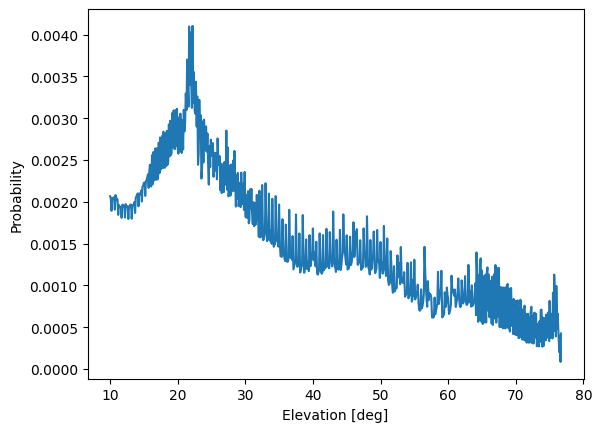

In [6]:
with open('./output/elevations/NN11_elevations.pickle', 'wb') as f:
    pickle.dump(elevations, f, protocol=pickle.HIGHEST_PROTOCOL)
nn = mani_rain.new_norcia
nn.gen_el_dist(file='./output/elevations/NN11_elevations.pickle')

plt.figure()
plt.plot(*nn.el_distribution)
plt.xlabel("Elevation [deg]")
plt.ylabel("Probability")
plt.show()

link = mani_rain.link_budget_itu(nn, 100e6)
# dist = 384400e3
# rain_rate = 4 #mmhr⁻¹
# rain_rates = np.full(len(elevations), rain_rate)
# snr_list = []
# for idx, el in enumerate(elevations):
#     snr_list.append(link.snr_at_t(dist, el, rain_rates[idx]))
# plt.figure()
# plt.plot(elevations, snr_list)
# plt.grid()
# plt.xlabel("Elevation [Deg]")
# plt.ylabel("SNR [dB]")
# plt.show()

In [15]:
rain_p = 0.5
dist = 384400e3
elev = 45
%timeit link.rain_model.p = rain_p
snr = link.snr_at_t(dist, elev)
rates = link.dvb_s2_cap(snr)

2.24 ms ± 3.62 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
from tqdm import tqdm


link = mani_rain.link_budget_itu(nn, 100e6)
dist = 384400e3

n_rains = int(np.ceil(len(res.df) / 60))

generator = np.random.default_rng()
does_rain_p = generator.binomial(1, 0.01, n_rains)

hmr = generator.uniform(0.01, 1, sum(does_rain_p))
idx = 0

rainrates = np.empty_like(does_rain_p)
for i, _ in enumerate(tqdm(rainrates)):
    if does_rain_p[i] > 0:
        link.rain_model.p = hmr[idx]
        rainrates[i] = link.rain_model.rain_rate
        idx += 1
    else:
        rainrates[i] = 0
rainrates = np.repeat(rainrates, 60)
print(rainrates.shape)
    
        
snrs = np.empty(len(elevations))
rates = np.empty(len(elevations))

for i, elev in enumerate(tqdm(elevations)):
    snrs[i] = link.snr_at_t(dist, elev, rainrates[i])
    rates[i] = link.dvb_s2_cap(snrs[i])

100%|██████████| 525601/525601 [00:11<00:00, 44238.86it/s]


(31536060,)


100%|██████████| 7620959/7620959 [00:49<00:00, 153861.31it/s]


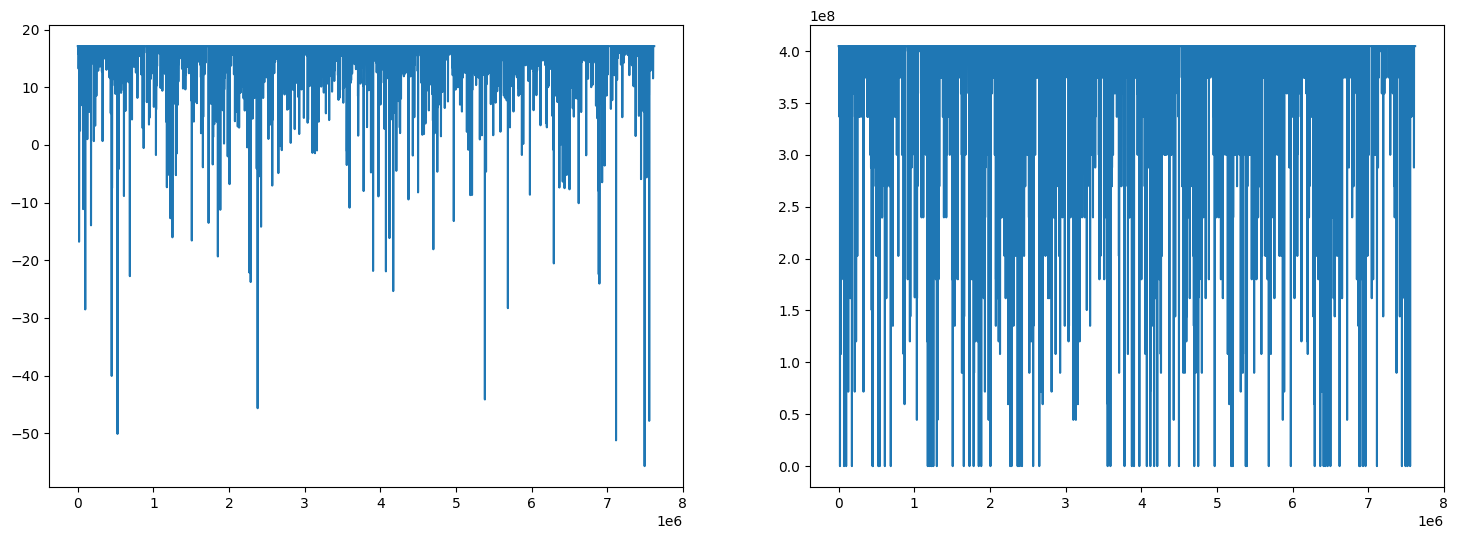

403.7109603821782


In [92]:
fig = plt.figure(figsize=(18, 6))
ax0, ax1 = fig.subplots(1,2)
ax0.plot(snrs)
#ax0.set_ylim(-3, 10)
ax1.plot(rates)
plt.show()
print(np.mean(rates) / 1e6)

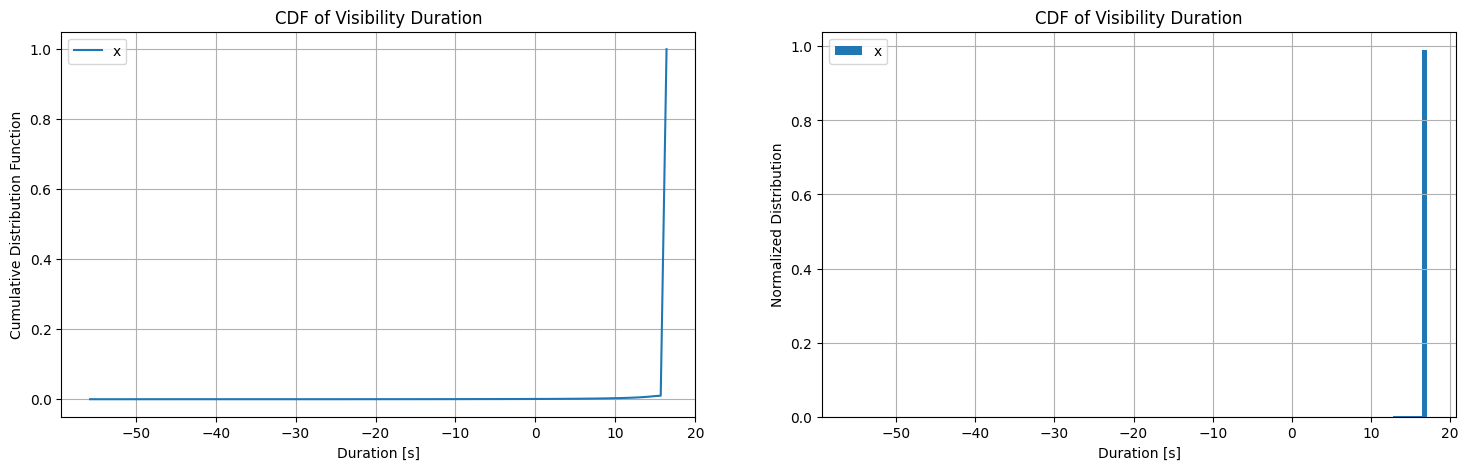

In [ ]:
def plot_cdf(ax, bins,vals, name):
    ax.plot(bins[:-1], np.cumsum(vals), label = name)
    ax.grid()
    ax.set_xlabel('Duration [s]')
    ax.set_ylabel('Cumulative Distribution Function')
    ax.legend()
    ax.set_title('CDF of Visibility Duration')

def plot_hist(ax, arr, name):
    ax.hist(arr, bins = 100, weights=np.ones(len(arr)) / len(arr), label = name)
    ax.grid()
    ax.set_xlabel('Duration [s]')
    ax.set_ylabel('Normalized Distribution')
    ax.set_title('CDF of Visibility Duration')
    ax.legend()


fig = plt.figure(figsize = (18,5))
ax0, ax1 = fig.subplots(1,2)
arr = snrs

name = 'x'
vals, bins = np.histogram(arr, bins=100, weights=np.ones(len(arr)) / len(arr))
plot_cdf(ax0, bins, vals, name)

plot_hist(ax1, arr, name)

plt.show()